In [1]:
file = '/content/drive/MyDrive/ML TASK-20251013T190503Z-1-001.zip'

In [2]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

'DATASET IMAGES & VIDEOS FOR AI-ML TASK'   drive   sample_data


In [ ]:
%pip install ultralytics

In [ ]:
%pip install deepface

In [7]:
from PIL import Image, ImageDraw
import torch, cv2, numpy as np, os, re
from ultralytics import YOLO
from transformers import (
    CLIPProcessor, CLIPModel,
    VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer,
    AutoModelForImageClassification, AutoImageProcessor
)
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML
from google.colab import files

25-10-17 12:30:47 - Directory /root/.deepface has been created
25-10-17 12:30:47 - Directory /root/.deepface/weights has been created


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

Running on: cpu


In [9]:
print("Loading models... This may take a moment.")
yolo = YOLO("yolov8n.pt")

# CLIP for scene classification & explicit check
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Captioning
caption_id = "nlpconnect/vit-gpt2-image-captioning"
cap_model = VisionEncoderDecoderModel.from_pretrained(caption_id).to(device)
cap_feat = ViTImageProcessor.from_pretrained(caption_id)
cap_tok = AutoTokenizer.from_pretrained(caption_id)

# Dedicated NSFW detection
print("Loading NSFW detection model...")
nsfw_model_id = "Falconsai/nsfw_image_detection"
nsfw_model = AutoModelForImageClassification.from_pretrained(nsfw_model_id).to(device)
nsfw_proc = AutoImageProcessor.from_pretrained(nsfw_model_id)

Loading models... This may take a moment.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Loading NSFW detection model...


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
def detect_objects(img):
    res = yolo.predict(source=np.array(img), conf=0.35, verbose=False)
    labels = set()
    for r in res:
        labels.update([r.names[int(c)] for c in r.boxes.cls.cpu().numpy()])
    return list(labels)

def classify_scene(img, class_list):
    inp = clip_proc(text=class_list, images=img, return_tensors="pt", padding=True).to(device)
    out = clip_model(**inp)
    probs = out.logits_per_image.softmax(dim=1)
    idx = probs[0].topk(3).indices
    return [class_list[i] for i in idx]

def get_embedding(img):
    with torch.no_grad():
        inputs = clip_proc(images=img, return_tensors="pt").to(device)
        emb = clip_model.get_image_features(**inputs).cpu().numpy()
    return emb

def face_analysis_if_person(img, objects_in_frame):
    if "person" not in [obj.lower() for obj in objects_in_frame]:
        return []
    arr = cv2.cvtColor(np.array(img.convert("RGB")), cv2.COLOR_RGB2BGR)
    try:
        faces = DeepFace.analyze(arr, actions=['age', 'gender'], enforce_detection=False)
        return faces if isinstance(faces, list) else [faces]
    except Exception:
        return []

def generate_caption_and_tags(img):
    pix = cap_feat(images=img, return_tensors="pt").pixel_values.to(device)
    out_ids = cap_model.generate(pix, max_length=20, num_beams=4)
    caption = cap_tok.decode(out_ids[0], skip_special_tokens=True).strip().capitalize()
    words = re.findall(r"\b[a-zA-Z]{4,}\b", caption.lower())
    tags = [f"#{w}" for w in dict.fromkeys(words)][:6]
    return caption, tags

def sample_video_frames(path, max_frames=5):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        print(f"⚠️ No frames found in video: {path}")
        cap.release()
        return []
    idxs = np.linspace(0, total - 1, max_frames).astype(int)
    frames = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, f = cap.read()
        if ret:
            frames.append(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)))
    cap.release()
    if not frames:
        print(f"⚠️ Failed to read any frames from video: {path}")
    return frames


def detect_explicit_image(img):
    """Detects explicit (NSFW) content using specialized model."""
    inputs = nsfw_proc(images=img, return_tensors="pt").to(device)
    outputs = nsfw_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    labels = nsfw_model.config.id2label
    top_label = labels[int(probs.argmax())]
    confidence = float(probs.max())
    return top_label, confidence

def convert_to_serializable(obj):
    if isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    else:
        return obj

def get_media_recommendations(upload_emb, dataset_embeddings, dataset_paths, top_k=3):
    sims = cosine_similarity(upload_emb.reshape(1, -1), dataset_embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [dataset_paths[i] for i in top_idx]

In [11]:
def prepare_dataset_embeddings(dataset_folder):
    dataset_paths = []
    dataset_embeddings = []

    images_folder = os.path.join(dataset_folder, "Images")
    videos_folder = os.path.join(dataset_folder, "Videos")

    print(f"🔍 Scanning dataset folders: {dataset_folder}")
    for root, _, files_in_dir in os.walk(images_folder):
        for f in files_in_dir:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, f)
                try:
                    img = Image.open(path).convert("RGB")
                    emb = get_embedding(img)
                    dataset_embeddings.append(emb)
                    dataset_paths.append(path)
                except Exception as e:
                    print(f"⚠️ Skipping image file {path} due to error: {e}")


    for root, _, files_in_dir in os.walk(videos_folder):
        for f in files_in_dir:
            if f.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                path = os.path.join(root, f)
                try:
                    frames = sample_video_frames(path, max_frames=3)
                    if frames:
                        emb = get_embedding(frames[0])
                        dataset_embeddings.append(emb)
                        dataset_paths.append(path)
                    else:
                         print(f"⚠️ Skipping video file {path} due to no valid frames.")
                except Exception as e:
                    print(f"⚠️ Skipping video file {path} due to error: {e}")


    if not dataset_embeddings:
        print("❌ No valid media files found in the dataset folder to compute embeddings.")
        return np.array([]), []

    dataset_embeddings = np.vstack(dataset_embeddings)
    dataset_embeddings = np.nan_to_num(dataset_embeddings, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"✅ Successfully computed embeddings for {len(dataset_paths)} files.")
    return dataset_embeddings, dataset_paths

In [12]:
def analyze_media(file_path, dataset_embeddings=None, dataset_paths=None):
    class_list = ["People", "Fashion", "Sports", "Food", "Nature", "Travel",
                  "Animals", "Architecture", "Technology", "Vehicles", "Art", "Military"]

    ext = os.path.splitext(file_path)[1].lower()
    frames = [Image.open(file_path).convert("RGB")] if ext in [".jpg", ".jpeg", ".png"] else sample_video_frames(file_path, 5)

    if not frames:
        return {"error": "No valid frames found for analysis."}

    all_objs, all_cats, all_faces, embeds = [], [], [], []

    for frame in frames:
        objs_in_frame = detect_objects(frame)
        all_objs += objs_in_frame
        all_cats += classify_scene(frame, class_list)

        frame_faces = face_analysis_if_person(frame, objs_in_frame)
        if frame_faces:
            all_faces = frame_faces  # only take first frame with faces
            break

        embeds.append(get_embedding(frame))

    embed_mean = np.mean(embeds, axis=0) if embeds else None # Handle empty embeds case
    if embed_mean is not None:
        embed_mean = np.nan_to_num(embed_mean, nan=0.0, posinf=0.0, neginf=0.0)

    top_cats = list(dict.fromkeys(all_cats))[:3]

    # Explicit detection (CLIP + NSFW)
    explicit_texts = ["safe photo", "explicit photo"]
    inp = clip_proc(text=explicit_texts, images=frames[0], return_tensors="pt", padding=True).to(device)
    out = clip_model(**inp)
    probs = out.logits_per_image.softmax(dim=1)
    clip_label = explicit_texts[int(probs.argmax())].capitalize()
    clip_prob = float(probs[0][int(probs.argmax())])

    nsfw_label, nsfw_conf = detect_explicit_image(frames[0])
    nsfw_label = nsfw_label.capitalize()

    if nsfw_label.lower() == "nsfw" or clip_label.lower() == "explicit photo":
        explicit_label = "Explicit Content Detected"
        explicit_prob = max(clip_prob, nsfw_conf)
    else:
        explicit_label = "Safe Content"
        explicit_prob = max(clip_prob, nsfw_conf)

    caption, tags = generate_caption_and_tags(frames[0])
    engagement_score = int(1000 + 150 * len(set(all_objs)) + 60 * len(all_faces))

    processed_faces = [convert_to_serializable(f) for f in all_faces]

    result = {
        "primary_category": top_cats[0] if top_cats else None,
        "top_categories": top_cats,
        "objects": list(set(all_objs)),
        "faces": processed_faces,
        "explicit_label": explicit_label,
        "explicit_probability": round(explicit_prob, 3),
        "caption": caption,
        "hashtags": tags,
        "predicted_engagement": engagement_score,
        "first_frame": frames[0]
    }

    # Recommendations
    if embed_mean is not None and dataset_embeddings is not None and dataset_embeddings.size > 0:
        recommended_media = get_media_recommendations(embed_mean, dataset_embeddings, dataset_paths, top_k=3)
        result["recommendations"] = recommended_media
    else:
        result["recommendations"] = []

    return convert_to_serializable(result)

In [18]:
def display_results(image_path, results, is_video=False):
    img = results.get('first_frame', None)
    if img:
        display(img)

    html_content = f"""
    <div style="border:2px solid #4CAF50; padding:15px; border-radius:10px; width:700px;">
        <h2 style="color:#4CAF50;">Analysis Results</h2>
        <p><b>Primary Category:</b> {results['primary_category']}</p>
        <p><b>Top Categories:</b> {', '.join(results['top_categories'])}</p>
        <p><b>Objects Detected:</b> {', '.join(results['objects'])}</p>
        <p><b>Faces Detected:</b></p>
        <ul>
    """

    if results['faces']:
        for face in results['faces']:
            gender_val = face.get('gender', None)
            if isinstance(gender_val, dict):
                gender = max(gender_val, key=gender_val.get)
            elif isinstance(gender_val, str):
                gender = "Man" if "male" in gender_val.lower() else "Woman" if "female" in gender_val.lower() else "N/A"
            elif isinstance(gender_val, (int, float)):
                gender = "Man" if gender_val >= 0.5 else "Woman"
            else:
                gender = "N/A"
            age = face.get('age', 'N/A')
            html_content += f"<li>Gender: {gender}, Age: {age}</li>"
    else:
        html_content += "<li>No people detected</li>"

    html_content += f"""
        </ul>
        <p><b>Caption:</b> {results['caption']}</p>
        <p><b>Hashtags:</b> {' '.join(results['hashtags'])}</p>
        <p><b>Explicit/Safe:</b> {results['explicit_label']} (Probability: {results['explicit_probability']})</p>
    """

    if results.get("recommendations"):
        html_content += "<p><b>Recommended Media:</b></p><ul>"
        for r in results["recommendations"]:
            html_content += f"<li>{r}</li>"
        html_content += "</ul>"

    html_content += "</div>"
    display(HTML(html_content))

In [14]:
dataset_folder = "/content/DATASET IMAGES & VIDEOS FOR AI-ML TASK"
dataset_embeddings, dataset_paths = prepare_dataset_embeddings(dataset_folder)

🔍 Scanning dataset folders: /content/DATASET IMAGES & VIDEOS FOR AI-ML TASK
✅ Successfully computed embeddings for 287 files.


📤 Please upload an image or video file for analysis:


Saving Gemini_Generated_Image_ai78tai78tai78ta.png to Gemini_Generated_Image_ai78tai78tai78ta.png

🔍 Analyzing external media: Gemini_Generated_Image_ai78tai78tai78ta.png


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


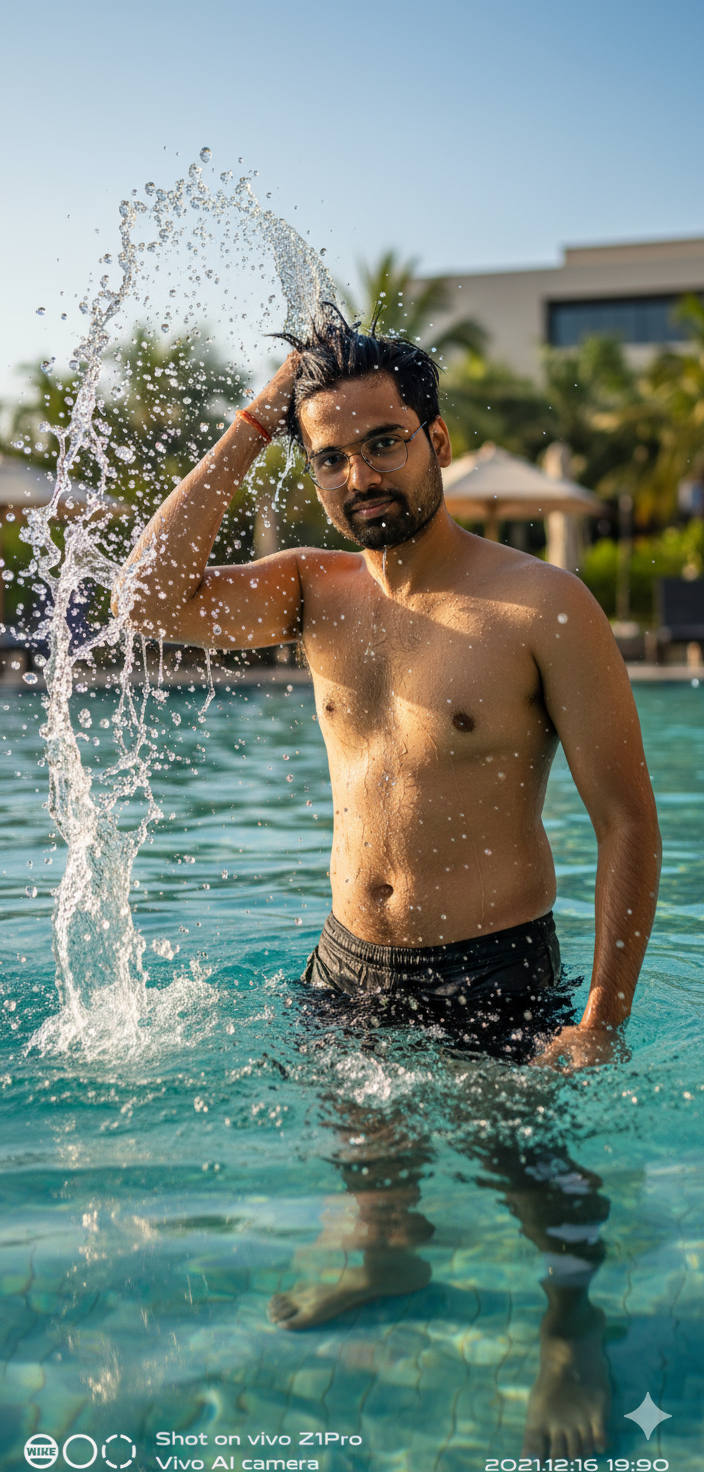

In [26]:
print("📤 Please upload an image or video file for analysis:")
uploaded = files.upload()
for fname in uploaded.keys():
    print(f"\n🔍 Analyzing external media: {fname}")
    results = analyze_media(fname, dataset_embeddings, dataset_paths)
    if "error" in results:
        print(f"❌ Error analyzing {fname}: {results['error']}")
    else:
        display_results(fname, results)